# Test

/home/francobertoldi/miniconda3/envs/cuda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/francobertoldi/miniconda3/envs/cuda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 62/62 [00:02<00:00, 24.71it/s]



Mejor reconstrucción:
Imagen: temp_valid/1a0a69b4-45f9-46a1-a9b7-dc1c4992947b.jpg
Error: 0.157736


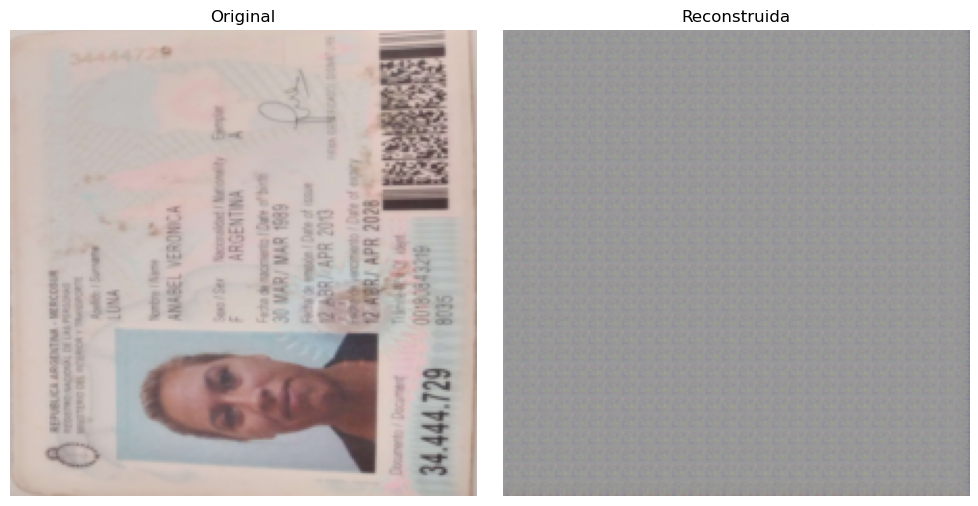

100%|██████████| 103/103 [00:04<00:00, 24.08it/s]



Mejor reconstrucción:
Imagen: temp_invalid/invalid_image_95.jpg
Error: 0.088891


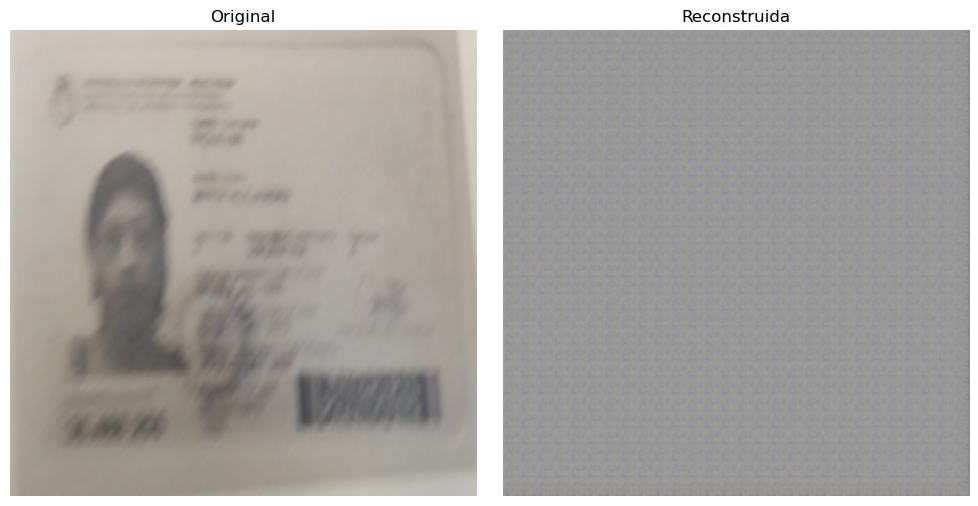

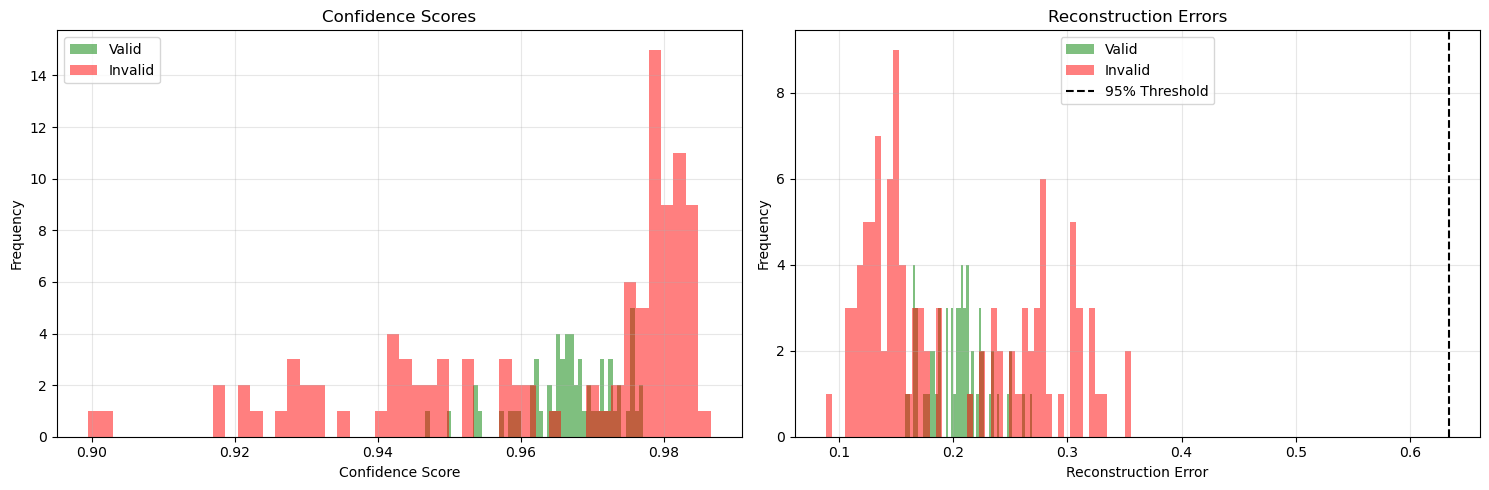


Model Statistics:
Valid - Mean Confidence: 0.967
Invalid - Mean Confidence: 0.963
Valid - Mean Error: 0.204
Invalid - Mean Error: 0.198
Thresholds: {'90': 0.6148480653762818, '95': 0.6338698744773864, '99': 0.6559972262382507}


In [1]:
import shutil
import torch
import numpy as np
from pathlib import Path
from ultralytics import YOLO
from torch.utils.data import DataLoader
from vae import DNIVAEDetector, DNIDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

def preprocess_images_with_yolo(yolo_model, input_dir, output_dir):
    """
    Detect and crop DNI images using YOLO.

    Args:
        yolo_model: YOLO model for detection
        input_dir: Directory containing input images
        output_dir: Directory to save processed images
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    image_paths = list(Path(input_dir).glob('*.jpg'))
    for img_path in tqdm(image_paths, desc=f"Processing {input_dir}"):
        try:
            results = yolo_model(str(img_path), verbose=False)[0]
            if not results.boxes:  # Skip if no detection
                continue

            # Get the best detection
            best_box = results.boxes[results.boxes.conf.argmax()]
            
            # Crop image
            bbox = best_box.xyxy[0].cpu().numpy()
            cropped_image = crop_image(Image.open(img_path), bbox)

            # Save to output directory
            cropped_image.save(Path(output_dir) / img_path.name)

        except Exception as e:
            print(f"Error processing {img_path.name}: {e}")

def crop_image(image, bbox):
    """Simple crop without reorientation"""
    x1, y1, x2, y2 = map(int, bbox)
    return image.crop((x1, y1, x2, y2))

def compute_reconstruction_stats(detector, data_dir):
    """
    Compute reconstruction statistics for a directory of images.
    """
    dataset = DNIDataset(data_dir, detector.transform)
    confidences = []
    errors = []
    
    min_error = float('inf')
    best_original = None
    best_reconstructed = None
    best_image_path = None
    
    for img_path in tqdm(dataset.image_paths):
        confidence, error, original, reconstructed = detector.predict(img_path, '95', return_images=True)
        confidences.append(confidence)
        errors.append(error)
        
        # Guardar la mejor reconstrucción
        if error < min_error:
            min_error = error
            best_original = original
            best_reconstructed = reconstructed
            best_image_path = img_path
            
    print(f"\nMejor reconstrucción:")
    print(f"Imagen: {best_image_path}")
    print(f"Error: {min_error:.6f}")
    
    # Mostrar las imágenes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.imshow(best_original.permute(1, 2, 0).cpu())
    ax1.set_title('Original')
    ax1.axis('off')
    
    ax2.imshow(best_reconstructed.permute(1, 2, 0).cpu().detach())
    ax2.set_title('Reconstruida')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
        
    return np.array(confidences), np.array(errors)

def plot_distributions(valid_conf, invalid_conf, valid_err, invalid_err, thresholds):
    """
    Plot confidence and error distributions.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Confidence plot
    ax1.hist(valid_conf, bins=50, alpha=0.5, label='Valid', color='green')
    ax1.hist(invalid_conf, bins=50, alpha=0.5, label='Invalid', color='red')
    ax1.set_title('Confidence Scores')
    ax1.set_xlabel('Confidence Score')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Error plot
    ax2.hist(valid_err, bins=50, alpha=0.5, label='Valid', color='green')
    ax2.hist(invalid_err, bins=50, alpha=0.5, label='Invalid', color='red')
    ax2.axvline(x=thresholds['95'], color='black', linestyle='--', label='95% Threshold')
    ax2.set_title('Reconstruction Errors')
    ax2.set_xlabel('Reconstruction Error')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_statistics(valid_conf, invalid_conf, valid_err, invalid_err, thresholds):
    """
    Print model statistics.
    """
    print("\nModel Statistics:")
    print(f"Valid - Mean Confidence: {valid_conf.mean():.3f}")
    print(f"Invalid - Mean Confidence: {invalid_conf.mean():.3f}")
    print(f"Valid - Mean Error: {valid_err.mean():.3f}")
    print(f"Invalid - Mean Error: {invalid_err.mean():.3f}")
    print(f"Thresholds: {thresholds}")

def evaluate_model(yolo_model_path, model_path, valid_dir, invalid_dir):
    """
    Evaluate model on valid and invalid images.
    
    Args:
        yolo_model_path: Path to YOLO model
        model_path: Path to anomaly detector model
        valid_dir: Directory containing valid images
        invalid_dir: Directory containing invalid images
    """
    # Load models
    yolo_model = YOLO(yolo_model_path)
    model = DNIVAEDetector(device='cuda' if torch.cuda.is_available() else 'cpu')
    model.load_model(model_path)
    
    # Create temp directories
    temp_valid = 'temp_valid'
    temp_invalid = 'temp_invalid'
    
    try:
        # Process images with YOLO
        preprocess_images_with_yolo(yolo_model, valid_dir, temp_valid)
        preprocess_images_with_yolo(yolo_model, invalid_dir, temp_invalid)
        
        # Compute statistics
        valid_conf, valid_err = compute_reconstruction_stats(model, temp_valid)
        invalid_conf, invalid_err = compute_reconstruction_stats(model, temp_invalid)
        
        # Plot and print results
        plot_distributions(valid_conf, invalid_conf, valid_err, invalid_err, model.thresholds)
        print_statistics(valid_conf, invalid_conf, valid_err, invalid_err, model.thresholds)
        
    finally:
        # Cleanup
        shutil.rmtree(temp_valid, ignore_errors=True)
        shutil.rmtree(temp_invalid, ignore_errors=True)

# Example usage
evaluate_model(
    yolo_model_path='api/best.pt',
    model_path='vae_model.pt',
    valid_dir='test/original/valid',
    invalid_dir='test/original/invalid'
)

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms

def test_autoencoder(model, image_path, save_path=None):
    """
    Test the autoencoder by reconstructing an image and visualizing the results.
    
    Args:
        model: DNIAnomalyDetector instance
        image_path: Path to the test image
        save_path: Optional path to save the visualization
    """
    # Prepare image
    image = Image.open(image_path).convert('RGB')
    image_tensor = model.transform(image).unsqueeze(0).to(model.device)
    
    # Get reconstruction
    model.encoder.eval()
    model.decoder.eval()
    with torch.no_grad():
        latent = model.encoder(image_tensor)
        reconstructed = model.decoder(latent)
    
    # Calculate reconstruction error
    mse_loss = torch.nn.functional.mse_loss(reconstructed, image_tensor).item()
    
    # Convert tensors to images for plotting
    original_img = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    reconstructed_img = reconstructed.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original
    axes[0].imshow(original_img)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Plot reconstruction
    axes[1].imshow(reconstructed_img)
    axes[1].set_title('Reconstructed')
    axes[1].axis('off')
    
    # Plot error map
    error_map = np.abs(original_img - reconstructed_img).mean(axis=2)
    im = axes[2].imshow(error_map, cmap='hot')
    axes[2].set_title(f'Error Map\nMSE: {mse_loss:.6f}')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
    return mse_loss

# Cargar el modelo entrenado
detector = DNIAnomalyDetector(device='cuda' if torch.cuda.is_available() else 'cpu')
detector.load_model('dni_anomaly_detector_new_hyper.pt')

# Test de una sola imagen
test_autoencoder(detector, 'test/valid/0a1e89f6-0ae2-4cab-854e-61c897cbbe13.jpg', save_path='resultado.png')

# test_autoencoder(detector, 'test/invalid/DniFrente 1.jpg', save_path='resultado.png')

# # Test de múltiples imágenes
# results = batch_test(detector, 'carpeta/con/imagenes', n_samples=5)

In [ ]:
detector = DNIAnomalyDetector(device='cuda' if torch.cuda.is_available() else 'cpu')
detector.load_model('dni_anomaly_detector_old.pt')

detector.threshold